In [1]:
import os
print(os.getcwd()) #print working dir
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import time
import json
from analyze_utilities import *
from dataset_utilities import create_cifar10_dataloaders
import pandas as pd
import copy
import seaborn as sns

C:\Users\uria\vmplayer_shared\Pnml_code\deep_pnml\src


In [2]:
%run ./result_summary_uriya.ipynb
print(files_nml_2_layers)

Loading paths from result_summary ...
['./../results/deep_net/lr_0.001_ep_16/mnist_adversarial_results_20190404_130659/results_mnist_adversarial_20190404_130659.json', './../results/deep_net/lr_0.001_ep_16/mnist_adversarial_results_20190404_130840/results_mnist_adversarial_20190404_130840.json', './../results/deep_net/lr_0.001_ep_16/mnist_adversarial_results_20190404_131448/results_mnist_adversarial_20190404_131448.json', './../results/deep_net/lr_0.001_ep_16/mnist_adversarial_results_20190404_131904/results_mnist_adversarial_20190404_131904.json']


In [42]:
output_path = '../results/figures'
is_plot_title = False
is_save_fig = True

In [3]:
print(plt.style.available)
print(plt.rcParams)
plt.style.use(['seaborn-darkgrid', 'seaborn-paper'])
label_size = 16
tick_size = 14
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=label_size)
plt.rc('axes', labelsize=label_size)
plt.rc('xtick', labelsize=tick_size)
plt.rc('ytick', labelsize=tick_size)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']
_internal.classic_mode: False
agg.path.chunksize: 0
animation.avconv_args: []
animation.avconv_path: avconv
animation.bitrate: -1
animation.codec: h264
animation.convert_args: []
animation.convert_path: convert
animation.embed_limit: 20.0
animation.ffmpeg_args: []
animation.ffmpeg_path: ffmpeg
animation.frame_format: png
animation.html: none
animation.html_args: []
animation.writer: ffmpeg
axes.autolimit_mode: data
axes.axisbelow: line
axes.edgecolor: k
axes.facecolor: w
axes.formatter.limits: [-7, 7]
axes.formatter.min_exponent: 0
axes.formatter.offset_thre

ytick.right: False


# PNML Vs. ERM Performence
PNML is as training is as following:
1. Train base model with all trainset
2. Freeze first layers (only enable updates of layer 5,6 in resnet20)
3. For each test sample:
    1. For each label:
        1. Add the test sample with the label to trainset
        2. Train for 10 epochs the model
        3. Keep probability of the test sample label which it was trained with
    2. Take all save probabilities and normalize them.
    3. Report the new probability assignment

In [ ]:
%run ./result_summary_uriya.ipynb
print(M23_path)
calc_erm_and_genie_stats(M11_path)

In [70]:
from importlib import reload
import analyze_utilities
reload(analyze_utilities)
from analyze_utilities import *
# Print acc and mean loss
tic = time.time()
result_df, statistics_df = load_results_to_df(cifar_natural_fgsm_fgsm_all)
print('result_df: loaded in {0:.2f} [s]'.format(time.time() - tic))
print(statistics_df.transpose())
print(result_df.shape[0])


result_df: loaded in 1.95 [s]
          acc  mean loss  std loss  mean entropy
nml    0.1035   6.681809  5.559718      0.506497
erm    0.0606  11.492872  6.113350      0.108482
genie  0.3281   5.697035  5.624509      0.133782
10000


Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
           dtype='int64')


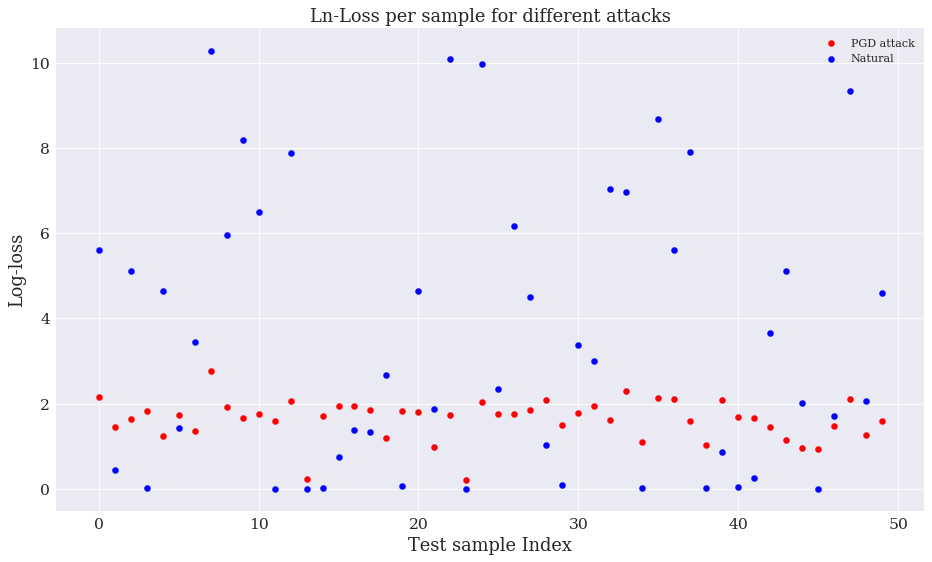

In [33]:
# Log-Loss vs sample index graph
ii = list(range(0,50)) # index range to display



result_df1, statistics_df = load_results_to_df(cifar_pgd_pgd_fgsm_all)
result_df2, statistics_df = load_results_to_df(cifar_pgd_pgd_fgsm_all)
result_df1 = result_df1.sort_index(axis=0)
result_df2 = result_df2.sort_index(axis=0)
print(result_df1.index[ii])
fig=plt.figure(figsize=(14, 8), dpi= 80, facecolor='w', edgecolor='k')
s1 = plt.scatter(result_df1.index[ii], result_df1['nml_loss'][ii], c="red")
s2 = plt.scatter(result_df2.index[ii], result_df2['erm_loss'][ii], c="blue")
plt.xlabel('Test sample Index')
plt.ylabel('Log-loss')
plt.legend((s1, s2),
           ('PGD attack', 'Natural'),
           scatterpoints=1,
           loc='upper right',
           ncol=1,
           fontsize=10)
plt.title('Ln-Loss per sample for different attacks')
plt.show()

## Accuracy Vs. refinement strength (delta)

Loading paths for pnml training...
loading paths for Twice universality with FGSM...
['./../results/cifar/acc_vs_eps_refine/cifar_adv_diff_fix_natural\\cifar_adversarial_results_20190826_073556\\results_cifar_adversarial_20190826_073556.json']
['./../results/cifar/acc_vs_eps_refine/cifar_adv_diff_fix_natural\\cifar_adversarial_results_20190826_073558\\results_cifar_adversarial_20190826_073558.json']
['./../results/cifar/acc_vs_eps_refine/cifar_adv_diff_fix_natural\\cifar_adversarial_results_20190826_073600\\results_cifar_adversarial_20190826_073600.json']
['./../results/cifar/acc_vs_eps_refine/cifar_adv_diff_fix_natural\\cifar_adversarial_results_20190826_073602\\results_cifar_adversarial_20190826_073602.json']
['./../results/cifar/acc_vs_eps_refine/cifar_adv_diff_fix_natural\\cifar_adversarial_results_20190826_073604\\results_cifar_adversarial_20190826_073604.json']
['./../results/cifar/acc_vs_eps_refine/cifar_adv_diff_fix_natural\\cifar_adversarial_results_20190826_073606\\results_ci

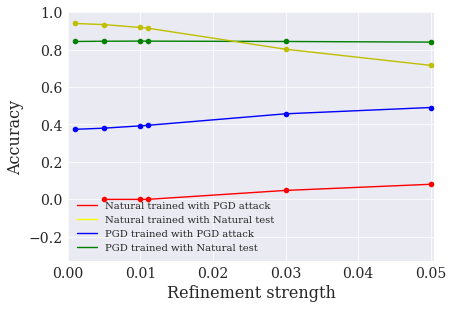

In [23]:
%run ./result_summary_uriya.ipynb
import matplotlib.lines as mlines
import matplotlib
import matplotlib.pyplot as plt
cifar_pgd_natural_df, _ = create_nml_vs_eps_df(cifar_pgd_natural_diff_refinement)
cifar_natural_natural_df, _ = create_nml_vs_eps_df(cifar_natural_natural_diff_refinement)
cifar_natural_pgd_df, _= create_nml_vs_eps_df((cifar_natural_pgd_diff_refinement))
cifar_pgd_pgd_df, _ = create_nml_vs_eps_df(cifar_pgd_pgd_diff_refinement)
axes = plt.gca()
axes.set_xlim([0.0, 0.0505])
axes.set_ylim([-0.33, 1.0])
l1 = plt.plot(cifar_pgd_natural_df['eps'],cifar_pgd_natural_df['acc'], 'go-')
l2 = plt.plot(cifar_natural_natural_df['eps'],cifar_natural_natural_df['acc'], 'yo-')
l3 = plt.plot(cifar_natural_pgd_df['eps'],cifar_natural_pgd_df['acc'], 'ro-')
l4 = plt.plot(cifar_pgd_pgd_df['eps'],cifar_pgd_pgd_df['acc'], 'bo-')
# l4
plt.xlabel('Refinement strength')
plt.ylabel('Accuracy')
# plt.title('Accuracy Vs. Refinement strength')

green_line = mlines.Line2D([], [], color='green', markersize=15, label='PGD trained with Natural test')
yellow_line = mlines.Line2D([], [], color='yellow', markersize=15, label='Natural trained with Natural test')
red_line = mlines.Line2D([], [], color='red', markersize=15, label='Natural trained with PGD attack')
blue_line = mlines.Line2D([], [], color='blue', markersize=15, label='PGD trained with PGD attack')
# plt.legend((l1, l3),
#            ('Natural trained with PGD attack', 'PGD trained with PGD attack'),
#            scatterpoints=1,
#            loc='upper right',
#            ncol=1,
#            fontsize=10)
plt.legend(handles=[red_line, yellow_line, blue_line, green_line], fontsize=10, ncol=1, loc=3)

plt.savefig(os.path.join(output_path, 'fig_mnist_acc_vs_refinement_strength.pdf'), dpi=200,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

## Accuracy Vs. Attack strength (epsilon)

Loading paths for pnml training...
loading paths for Twice universality with FGSM...


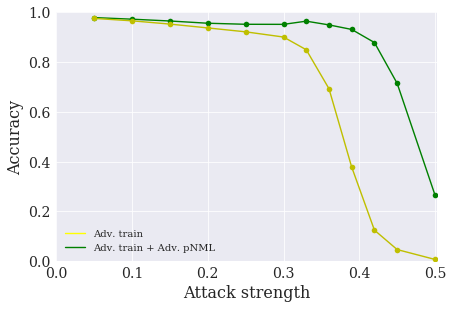

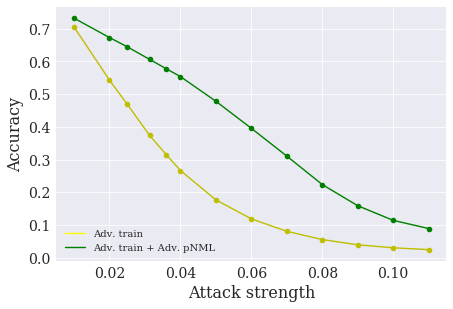

./../results/MNIST/mnist_adv_model_diff_eps_adaptive
['./../results/MNIST/mnist_adv_model_diff_eps_adaptive\\mnist_adversarial_results_20190905_154222\\results_mnist_adversarial_20190905_154222.json']
['./../results/MNIST/mnist_adv_model_diff_eps_adaptive\\mnist_adversarial_results_20190905_154630\\results_mnist_adversarial_20190905_154630.json']
['./../results/MNIST/mnist_adv_model_diff_eps_adaptive\\mnist_adversarial_results_20190905_155039\\results_mnist_adversarial_20190905_155039.json']
['./../results/MNIST/mnist_adv_model_diff_eps_adaptive\\mnist_adversarial_results_20190905_155447\\results_mnist_adversarial_20190905_155447.json']
['./../results/MNIST/mnist_adv_model_diff_eps_adaptive\\mnist_adversarial_results_20190905_155855\\results_mnist_adversarial_20190905_155855.json']
['./../results/MNIST/mnist_adv_model_diff_eps_adaptive\\mnist_adversarial_results_20190905_160346\\results_mnist_adversarial_20190905_160346.json']
['./../results/MNIST/mnist_adv_model_diff_eps_adaptive\\mni

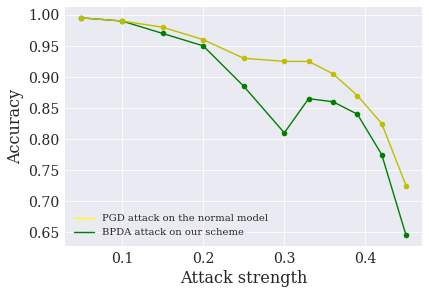

In [73]:
%run ./result_summary_uriya.ipynb
import matplotlib.lines as mlines
import matplotlib
import matplotlib.pyplot as plt

## MNIST
# mnist_pgd_pgd_diff_eps_nml_df, mnist_pgd_pgd_diff_eps_erm_df = create_nml_vs_eps_df(mnist_pgd_pgd_diff_eps, eps_type="attack")
axes = plt.gca()
axes.set_xlim([0.0, 0.502])
axes.set_ylim([-0.0, 1.0])
l1 = plt.plot(mnist_pgd_pgd_diff_eps_nml_df['eps'],mnist_pgd_pgd_diff_eps_nml_df['acc'], 'go-')
l2 = plt.plot(mnist_pgd_pgd_diff_eps_erm_df['eps'],mnist_pgd_pgd_diff_eps_erm_df['acc'], 'yo-')
# l4
plt.xlabel('Attack strength')
plt.ylabel('Accuracy')
# plt.title('Accuracy Vs. Refinement strength')

green_line = mlines.Line2D([], [], color='green', markersize=15, label='Adv. train + Adv. pNML')
yellow_line = mlines.Line2D([], [], color='yellow', markersize=15, label='Adv. train')
# plt.legend((l1, l3),
#            ('Natural trained with PGD attack', 'PGD trained with PGD attack'),
#            scatterpoints=1,
#            loc='upper right',
#            ncol=1,
#            fontsize=10)
plt.legend(handles=[yellow_line, green_line], fontsize=10, ncol=1, loc=3)

plt.savefig(os.path.join(output_path, 'fig_mnist_acc_vs_attack_strength.pdf'), dpi=200,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

## CIFAR
# cifar_pgd_pgd_diff_eps_nml_df, cifar_pgd_pgd_diff_eps_erm_df = create_nml_vs_eps_df(cifar_pgd_pgd_diff_eps_final, eps_type="attack")
plt.figure()
l1 = plt.plot(cifar_pgd_pgd_diff_eps_nml_df['eps'],cifar_pgd_pgd_diff_eps_nml_df['acc'], 'go-')
l2 = plt.plot(cifar_pgd_pgd_diff_eps_erm_df['eps'],cifar_pgd_pgd_diff_eps_erm_df['acc'], 'yo-')
plt.legend(handles=[yellow_line, green_line], fontsize=10, ncol=1, loc=3)
plt.xlabel('Attack strength')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(output_path, 'figure_cifar_acc_vs_attack_strength.pdf'), dpi=200,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()


## ADAPTIVE ATTACK
plt.figure()
print(mnist_bpda_diff_eps)
mnist_bpda_diff_eps_nml_df, _ = create_nml_vs_eps_df(mnist_bpda_diff_eps, eps_type="attack")
_, mnist_pgd_diff_eps_erm_df = create_nml_vs_eps_df(mnist_bpda_diff_eps, eps_type="attack")
l1 = plt.plot(mnist_bpda_diff_eps_nml_df['eps'],mnist_bpda_diff_eps_nml_df['acc'], 'go-')
l2 = plt.plot(mnist_pgd_diff_eps_erm_df['eps'],mnist_pgd_diff_eps_erm_df['acc'], 'yo-')
green_line = mlines.Line2D([], [], color='green', markersize=15, label='BPDA attack on our scheme')
yellow_line = mlines.Line2D([], [], color='yellow', markersize=15, label='PGD attack on the normal model')
plt.legend(handles=[yellow_line, green_line], fontsize=10, ncol=1, loc=3)
plt.xlabel('Attack strength')
plt.ylabel('Accuracy')
# plt.savefig(os.path.join(output_path, 'figure_cifar_acc_vs_attack_strength.pdf'), dpi=200,
#             bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

### Hyperparameters search
MNIST
Adaptive Vs. Normal PGD

In [60]:
%run ./result_summary_uriya.ipynb
from importlib import reload
import pandas as pd
import numpy as np
import analyze_utilities
reload(analyze_utilities)
from analyze_utilities import *
import matplotlib.lines as mlines
import matplotlib
import matplotlib.pyplot as plt
# mnist_hyperparam_pgd_attack_df, _ = create_nml_vs_eps_df(mnist_hyperparam_pgd_attack, eps_type="fix")
mnist_hyperparam_adaptive_attack_df, _ = create_nml_vs_eps_df(mnist_hyperparam_adaptive_attack, eps_type="fix")

mnist_hyperparam_pgd_attack_df = mnist_hyperparam_pgd_attack_df.sort_index()
exp_num = 1

for i in range(len(mnist_hyperparam_pgd_attack_df)):
    mnist_hyperparam_pgd_attack_df.loc[i, 'exp_num'] = exp_num
    params_hash = mnist_hyperparam_pgd_attack_df.loc[i, 'params_fix_hash']
#     compare_param_hash = mnist_hyperparam_pgd_attack_df.loc[i,'params_hash'] == \
#                                        mnist_hyperparam_adaptive_attack_df.params_hash
#     print(compare_param_hash)
#     mnist_hyperparam_pgd_attack_df.loc[compare_param_hash, 'exp_num'] = exp_num
    for j in range(len(mnist_hyperparam_adaptive_attack_df)):
        if params_hash == mnist_hyperparam_adaptive_attack_df.loc[j, 'params_fix_hash']:
            mnist_hyperparam_adaptive_attack_df.loc[j, 'exp_num'] = exp_num
            
    exp_num += 1
mnist_hyperparam_adaptive_attack_df = mnist_hyperparam_adaptive_attack_df.sort_values('exp_num')
# print(mnist_hyperparam_adaptive_attack_df)
for i in range(len(mnist_hyperparam_adaptive_attack_df)):
    if pd.isnull(mnist_hyperparam_adaptive_attack_df.loc[i, 'exp_num']):
        mnist_hyperparam_adaptive_attack_df.loc[i, 'exp_num'] = exp_num
        exp_num += 1
        

l1 = plt.plot(mnist_hyperparam_pgd_attack_df['exp_num'], mnist_hyperparam_pgd_attack_df['acc'], 'go-')
l2 = plt.plot(mnist_hyperparam_adaptive_attack_df['exp_num'], mnist_hyperparam_adaptive_attack_df['acc'], 'yo-')
plt.axhline(y=0.91, color='r', linestyle='-') 

axes = plt.gca()
# axes.set_xlim([0.0, 0.502])
axes.set_ylim([0.79, 1.00])
plt.xlabel('Experiment number')
plt.ylabel('Accuracy')
# plt.title('Accuracy Vs. Refinement strength')

green_line = mlines.Line2D([], [], color='green', markersize=15, label='Adv. pNML Vs PGD attack')
yellow_line = mlines.Line2D([], [], color='yellow', markersize=15, label='Adv. pNML Vs Adaptive attack')
red_line = mlines.Line2D([], [], color='red', markersize=15, label='ERM Vs. PGD')

plt.legend(handles=[yellow_line, green_line, red_line], fontsize=10, ncol=1, loc=3)

# plt.savefig(os.path.join(output_path, 'fig_mnist_acc_vs_attack_strength.pdf'), dpi=200,
#             bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

Loading paths from result_summary ...
Iteration 0 Loading:['./../results/MNIST/mnist_param_search_adaptive\\mnist_adversarial_results_20190909_181017\\results_mnist_adversarial_20190909_181017.json']
Iteration 1 Loading:['./../results/MNIST/mnist_param_search_adaptive\\mnist_adversarial_results_20190909_181019\\results_mnist_adversarial_20190909_181019.json']
Iteration 2 Loading:['./../results/MNIST/mnist_param_search_adaptive\\mnist_adversarial_results_20190909_181021\\results_mnist_adversarial_20190909_181021.json']
Iteration 3 Loading:['./../results/MNIST/mnist_param_search_adaptive\\mnist_adversarial_results_20190909_181023\\results_mnist_adversarial_20190909_181023.json']
Iteration 4 Loading:['./../results/MNIST/mnist_param_search_adaptive\\mnist_adversarial_results_20190909_181025\\results_mnist_adversarial_20190909_181025.json']
Iteration 5 Loading:['./../results/MNIST/mnist_param_search_adaptive\\mnist_adversarial_results_20190909_181639\\results_mnist_adversarial_20190909_1816

Iteration 53 Loading:['./../results/MNIST/mnist_param_search_adaptive\\mnist_adversarial_results_20190911_073042\\results_mnist_adversarial_20190911_073042.json']
Iteration 54 Loading:['./../results/MNIST/mnist_param_search_adaptive\\mnist_adversarial_results_20190911_073044\\results_mnist_adversarial_20190911_073044.json']
Iteration 55 Loading:['./../results/MNIST/mnist_param_search_adaptive\\mnist_adversarial_results_20190911_073046\\results_mnist_adversarial_20190911_073046.json']
Iteration 56 Loading:['./../results/MNIST/mnist_param_search_adaptive\\mnist_adversarial_results_20190911_074034\\results_mnist_adversarial_20190911_074034.json']
Iteration 57 Loading:['./../results/MNIST/mnist_param_search_adaptive\\mnist_adversarial_results_20190911_074036\\results_mnist_adversarial_20190911_074036.json']
Iteration 58 Loading:['./../results/MNIST/mnist_param_search_adaptive\\mnist_adversarial_results_20190911_074039\\results_mnist_adversarial_20190911_074039.json']
Iteration 59 Loading:[

NameError: name 'mnist_hyperparam_pgd_attack_df' is not defined

In [65]:
for i in range(len(mnist_hyperparam_pgd_attack_df.loc[mnist_hyperparam_pgd_attack_df.acc >= 0.92])):
    print(mnist_hyperparam_pgd_attack_df.loc[i, 'params']['fit_to_sample'])
# print(mnist_hyperparam_pgd_attack_df.loc[mnist_hyperparam_pgd_attack_df.acc >= 0.92][['params', 'acc']])
good_exp_num = mnist_hyperparam_pgd_attack_df.loc[mnist_hyperparam_pgd_attack_df.acc >= 0.92].exp_num.tolist()
print(good_exp_num)
print(mnist_hyperparam_adaptive_attack_df.loc[mnist_hyperparam_adaptive_attack_df.exp_num.isin(good_exp_num)][['exp_num', 'acc','eps', 'refine_iter', 'refine_random_start', 'refine_restart_num', 'results_path']])
print(mnist_hyperparam_pgd_attack_df.loc[mnist_hyperparam_pgd_attack_df.exp_num.isin(good_exp_num)][['exp_num', 'acc','eps', 'refine_iter', 'refine_random_start', 'refine_restart_num', 'results_path', 'mean loss']])

# print(mnist_hyperparam_adaptive_attack_df.loc[mnist_hyperparam_adaptive_attack_df.refine_iter == 1][['refine_iter', 'refine_random_start', 'acc','results_path']])

    refine_iter refine_random_start    acc  \
0           1.0                True  0.980   
25          1.0                True  0.960   
26          1.0                True  0.960   
1           1.0                True  0.970   
36          1.0               False    NaN   
27          1.0                True  0.965   
38          1.0               False    NaN   
2           1.0                True  0.980   
40          1.0               False    NaN   
28          1.0                True  0.980   
3           1.0                True  0.975   
29          1.0                True  0.990   
42          1.0               False    NaN   
4           1.0                True  0.990   

                                         results_path  
0   ./../results/MNIST/mnist_param_search_adaptive...  
25  ./../results/MNIST/mnist_param_search_adaptive...  
26  ./../results/MNIST/mnist_param_search_adaptive...  
1   ./../results/MNIST/mnist_param_search_adaptive...  
36  ./../results/MNIST/mnist_

Loading paths from result_summary ...


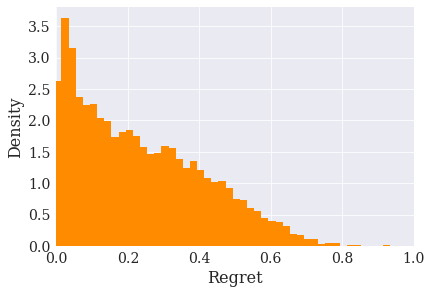

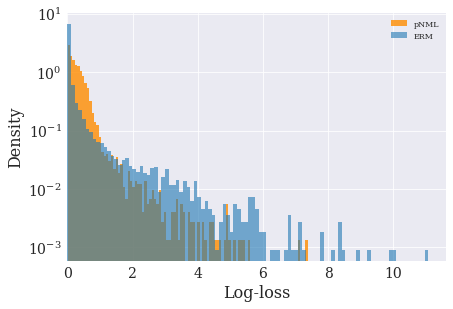

In [6]:
# Regret histogram
%run ./result_summary_uriya.ipynb
result_df, statistics_df = load_results_to_df(mnist_pgd_pgd_fgsm_all)
bins = 100
plt.hist(result_df['log_norm_factor'], density=True,
         label='pNML', bins=bins, color='darkorange')
plt.xlim([-0.0001, 1])
plt.title('Regret Histogram') if is_plot_title else None
plt.xlabel('Regret')
plt.ylabel('Density')
# plt.savefig(os.path.join(output_path, 'regret_hist.jpg'), dpi=200,
#             bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

# logloss histogram
bins = 100
plt.hist(result_df['nml_loss'], bins=bins, alpha=0.8,
         label='pNML', density=True, color='darkorange')
plt.hist(result_df['erm_loss'], bins=bins,
         alpha=0.6, label='ERM', density=True)
plt.title('Logloss Histogram') if is_plot_title else None
plt.xlabel('Log-loss')
plt.ylabel('Density')
plt.yscale('log')
plt.xlim(left=0)
plt.legend()
plt.savefig(os.path.join(output_path, 'logloss_hist.jpg'), dpi=200,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()


C:\DevPrograms\Anaconda2\envs\deep_pnml2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\DevPrograms\Anaconda2\envs\deep_pnml2\lib\site-packages\matplotlib\colors.py:1133: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh


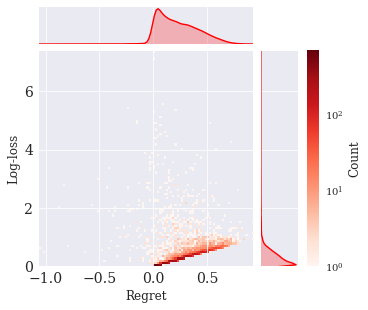

In [7]:
x_data = list(result_df['log_norm_factor'])
y_data = list(result_df['nml_loss'])
g = sns.JointGrid(x=x_data,  y=y_data)
g.plot_marginals(sns.kdeplot, shade=True, color='red')
g.plot_joint(plt.hist2d, bins=[100, 100], norm=mpl.colors.SymLogNorm(0.1),
             cmin=1, cmap=plt.cm.Reds)
g.ax_joint.grid(True)
g.ax_joint.set_ylabel('Log-loss', fontsize=label_size-4)
g.ax_joint.set_xlabel('Regret', fontsize=label_size-4)

# make new ax object for the cbar
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
cbar_ax = g.fig.add_axes([.82, 0.2, .03, .5])  # x, y, width, height
plt.colorbar(cax=cbar_ax).set_label(label='Count', fontsize=label_size-4)
cbar_ax.tick_params(labelsize=10)
plt.savefig(os.path.join(output_path, 'loss_vs_regret_jointplot.jpg'), dpi=200,
            bbox_inches='tight',  bbox_extra_artists=(cbar_ax,),) if is_save_fig else None
plt.show()

C:\DevPrograms\Anaconda2\envs\deep_pnml2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


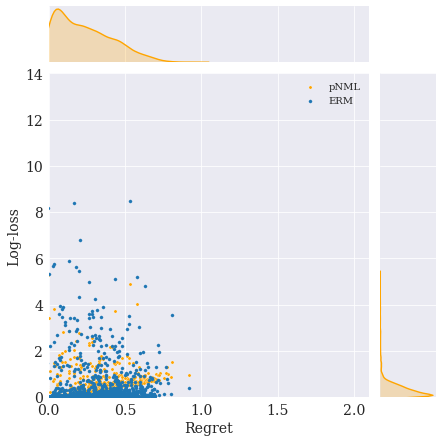

In [8]:
subsample = 5

x_data = list(result_df['log_norm_factor'][::subsample])
y_data = list(result_df['nml_loss'][::subsample])
g = sns.JointGrid(x=x_data,  y=y_data,  xlim=(0, 2.1), ylim=(0,14))
g.plot_marginals(sns.kdeplot, shade=True, color='orange')
g.plot_joint(plt.scatter, c='orange',  edgecolor="white", label='pNML', s=10)
# add scatter of erm
g.x = result_df['log_norm_factor'][::subsample]
g.y = result_df['erm_loss'][::subsample]
g.plot_joint(plt.scatter, c='C0', label='ERM', s=10)

g.ax_joint.grid(True)
g.ax_joint.set_ylabel('Log-loss', fontsize=label_size-2)
g.ax_joint.set_xlabel('Regret', fontsize=label_size-2)

plt.legend(prop={'size': 10})
plt.savefig(os.path.join(output_path, 'loss_vs_regret_jointplot_scatter.jpg'), dpi=200,
            bbox_inches='tight',  bbox_extra_artists=(cbar_ax,),) if is_save_fig else None
plt.show()

Loading paths from result_summary ...


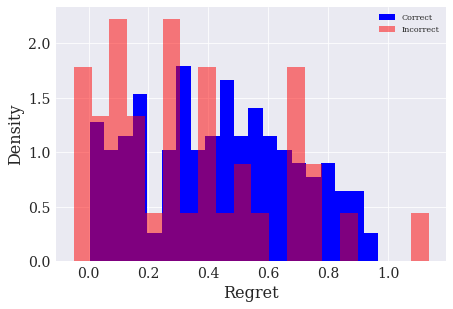


Correct = 162, Incorrect = 38 
Mean [correct, incorrect]=[0.43577790863107063, 0.33833960698044435]


In [30]:
# Plot histogram of correct vs incorrect
%run ./result_summary_uriya.ipynb
result_df, statistics_df = load_results_to_df(mnist_bpda1)
correct_norm_factor = result_df['log_norm_factor'][result_df['nml_is_correct'] == True]
incorrect_norm_factor = result_df['log_norm_factor'][result_df['nml_is_correct'] == False]

bins = 20

plt.hist(correct_norm_factor, alpha=1, bins=bins,
         density=True, color='blue', label='Correct')
plt.hist(incorrect_norm_factor, alpha=0.5, bins=bins,
         density=True, color='red', label='Incorrect')
plt.title(
    'Regret Histogram with Correct and Incorrect Separation') if is_plot_title else None
plt.xlabel('Regret')
plt.ylabel('Density')
plt.legend()
plt.savefig(os.path.join(output_path, 'correct_incorrect_hist.jpg'), dpi=200,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

print()
print('Correct = %d, Incorrect = %d ' %
      (correct_norm_factor.shape[0], incorrect_norm_factor.shape[0]))
print('Mean [correct, incorrect]={}'.format(
    [correct_norm_factor.mean(), incorrect_norm_factor.mean()]))

# Compose Regret based Estimator

In [10]:
#  Construct best loss based on normalization factor
threshold_list = np.linspace(np.finfo(float).eps, 1, 99)
acc_list = []
acc_erm_list = []
cdf_list = []
nml_thresh_loss_list = []
erm_thresh_loss_list = []
for threshold in threshold_list:
    df = result_df[result_df['log_norm_factor'] < threshold]

    # loss
    nml_thresh_loss_list.append(df['nml_loss'].mean())
    erm_thresh_loss_list.append(df['erm_loss'].mean())

    # Acc
    acc_single = np.sum(df['nml_is_correct'] == True) / \
        (df.shape[0] + np.finfo(float).eps)
    acc_list.append(acc_single)
    acc_erm_single = np.sum(df['erm_is_correct'] == True) / \
        (df.shape[0] + np.finfo(float).eps)
    acc_erm_list.append(acc_erm_single)

    cdf_single = df.shape[0] / result_df.shape[0]
    cdf_list.append(cdf_single)

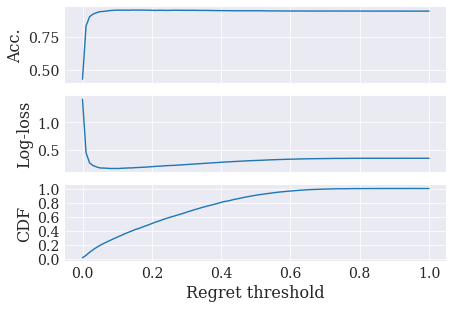

In [11]:
gs = gridspec.GridSpec(3, 1)
# Acc
acc_color = 'royalblue'
ax1 = plt.subplot(gs[0])
ax1.plot(threshold_list, acc_list)
ax1.set_ylabel('Acc.')

labels = [item.get_text() for item in ax1.get_xticklabels()]
empty_string_labels = [''] * len(labels)
ax1.set_xticklabels(empty_string_labels)

# Loss
loss_color = 'green'
ax2 = plt.subplot(gs[1])
ax2.plot(threshold_list, nml_thresh_loss_list)
ax2.set_ylabel('Log-loss')
labels = [item.get_text() for item in ax2.get_xticklabels()]
empty_string_labels = [''] * len(labels)
ax2.set_xticklabels(empty_string_labels)

# CDF
ax3 = plt.subplot(gs[2])
ax3.plot(threshold_list, cdf_list)
ax3.set_yticks(np.linspace(0, 1, 6))
ax3.set_xlabel('Regret threshold')
ax3.set_ylabel('CDF')

# Save and show
plt.savefig(os.path.join(output_path, 'regret_based_calss_all.jpg'),
            dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

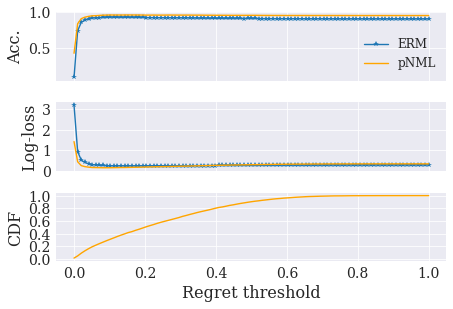

,CDF,Regret thresh,acc
0,0.0122,2.220446e-16,0.426230
1,0.0467,1.020408e-02,0.837259
2,0.0898,2.040816e-02,0.908686
3,0.1269,3.061224e-02,0.929078
4,0.1604,4.081633e-02,0.940150
5,0.1908,5.102041e-02,0.948113
6,0.2159,6.122449e-02,0.949514
7,0.2407,7.142857e-02,0.953469
8,0.2642,8.163265e-02,0.956851
9,0.2877,9.183673e-02,0.958290


In [12]:
gs = gridspec.GridSpec(3, 1)
# Acc
acc_color = 'royalblue'
ax1 = plt.subplot(gs[0])
ax1.plot(threshold_list, acc_erm_list, '-*' , label='ERM', color='C0')
ax1.plot(threshold_list, acc_list, label='pNML', color='orange')
ax1.set_ylabel('Acc.')
plt.legend(fontsize=12)

labels = [item.get_text() for item in ax1.get_xticklabels()]
empty_string_labels = [''] * len(labels)
ax1.set_xticklabels(empty_string_labels)

# Loss
loss_color = 'green'
ax2 = plt.subplot(gs[1])
ax2.plot(threshold_list, erm_thresh_loss_list, '-*' , label='ERM', color='C0')
ax2.plot(threshold_list, nml_thresh_loss_list, label='pNML', color='orange')
ax2.set_ylabel('Log-loss')
labels = [item.get_text() for item in ax2.get_xticklabels()]
empty_string_labels = [''] * len(labels)
ax2.set_xticklabels(empty_string_labels)

# CDF
ax3 = plt.subplot(gs[2])
ax3.plot(threshold_list, cdf_list, color='orange')
ax3.set_yticks(np.linspace(0, 1, 6))
ax3.set_xlabel('Regret threshold')
ax3.set_ylabel('CDF')

# Save and show
plt.savefig(os.path.join(output_path, 'regret_based_class_all_with_erm.jpg'),
            dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

pd.DataFrame({'CDF': cdf_list, 'Regret thresh': threshold_list, 'acc': acc_list})

# Regret histogram of adversarial and natural samples

In [21]:
# Load svhn and noise
results_df_natural, statistic_natural = load_results_to_df(mnist_pgd_natural_fgsm_all)
print('Natural: loaded %d keys' % results_df_natural.shape[0])
results_df_fgsm, statistic_fgsm = load_results_to_df(mnist_pgd_fgsm_fgsm_all)
print('FGSM: loaded %d keys' % results_df_fgsm.shape[0])
results_df_pgd, statistic_pgd = load_results_to_df(mnist_pgd_pgd_fgsm_all)
print('PGD: loaded %d keys' % results_df_pgd.shape[0])

results_df_adaptive, statistic_adaptive = load_results_to_df(mnist_bpda1)
print('Adaptive: loaded %d keys' % results_df_adaptive.shape[0])

Natural: loaded 10000 keys
FGSM: loaded 10000 keys
PGD: loaded 10000 keys
Adaptive: loaded 200 keys


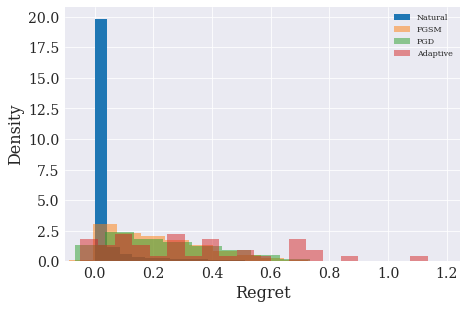

Mean: Natural, fgsm, pgd, adaptive: [0.03214013826398175, 0.20847329861709232, 0.2309162249302206, 0.41726463131745173]
Mean: Natural, fgsm, pgd, adaptive of incorrect only: [0.3376712509207619, 0.2967563350181107, 0.23612061558570882, 0.33833960698044435]


In [64]:
# Plot
bins = 20
plt.hist(results_df_natural['log_norm_factor'], alpha=1, density=True, label='Natural', bins=bins)
plt.hist(results_df_fgsm['log_norm_factor'], alpha=0.5, density=True, label='FGSM', bins=bins)
plt.hist(results_df_pgd['log_norm_factor'], alpha=0.5, density=True, label='PGD', bins=bins)
plt.hist(results_df_adaptive['log_norm_factor'], alpha=0.5, density=True, label='Adaptive', bins=bins)
plt.ylabel('Density')
plt.xlabel('Regret')
# plt.xlim([-0.1 1.2])
plt.xlim(left=-0.1)
# plt.yscale("log")
plt.title('Regret Histogram of natural and adversarial MNIST') if is_plot_title else None
plt.legend()
plt.savefig(os.path.join(output_path, 'adv_natural_hist.jpg'),
            dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()
print('Mean: Natural, fgsm, pgd, adaptive: {}'.format([results_df_natural['log_norm_factor'].mean(),
                                             results_df_fgsm['log_norm_factor'].mean(),
                                             results_df_pgd['log_norm_factor'].mean(),
                                             results_df_adaptive['log_norm_factor'].mean()]))

print('Mean: Natural, fgsm, pgd, adaptive of incorrect only: {}'.format([results_df_natural['log_norm_factor'][results_df_natural['nml_is_correct'] == False].mean(),
                                             results_df_fgsm['log_norm_factor'][results_df_fgsm['nml_is_correct'] == False].mean(),
                                             results_df_pgd['log_norm_factor'][results_df_pgd['nml_is_correct'] == False].mean(),
                                             results_df_adaptive['log_norm_factor'][results_df_adaptive['nml_is_correct'] == False].mean()]))


### Risk based detector for Adversarial images

Loading paths from result_summary ...
['./../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234628', './../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234630', './../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234632', './../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234634', './../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234636', './../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234638', './../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234640', './../results/MNIST/mnist_param_search_noattack\\mnist_adversarial_results_20190916_234642']
iteration 0
Dir: ./../results/MNIST/mnist_param_search_adaptive_1iter\mnist_adversarial_results_20190916_232729 No match eps1: 0.01 eps2: 0.02
Dir: ./../results/MNIST/mnist_param_search_adaptive_1iter\mnist_adversaria

Dir: ./../results/MNIST/mnist_param_search_pgd_1iter\mnist_adversarial_results_20190917_084900 No match eps1: 0.05 eps2: 0.05
iteration 5
Dir: ./../results/MNIST/mnist_param_search_pgd_1iter\mnist_adversarial_results_20190917_084246 No match eps1: 0.06 eps2: 0.01
Dir: ./../results/MNIST/mnist_param_search_pgd_1iter\mnist_adversarial_results_20190917_084317 No match eps1: 0.06 eps2: 0.02
Dir: ./../results/MNIST/mnist_param_search_pgd_1iter\mnist_adversarial_results_20190917_084511 No match eps1: 0.06 eps2: 0.03
Dir: ./../results/MNIST/mnist_param_search_pgd_1iter\mnist_adversarial_results_20190917_084713 No match eps1: 0.06 eps2: 0.04
Dir: ./../results/MNIST/mnist_param_search_pgd_1iter\mnist_adversarial_results_20190917_084900 No match eps1: 0.06 eps2: 0.05
Dir: ./../results/MNIST/mnist_param_search_pgd_1iter\mnist_adversarial_results_20190917_085103 No match eps1: 0.06 eps2: 0.06
iteration 6
Dir: ./../results/MNIST/mnist_param_search_pgd_1iter\mnist_adversarial_results_20190917_084246

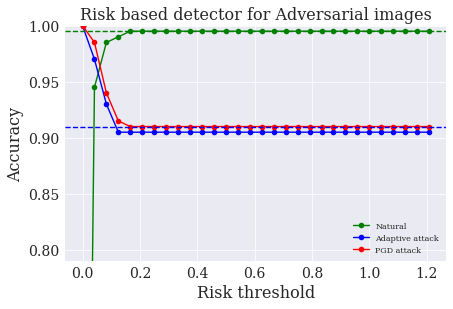

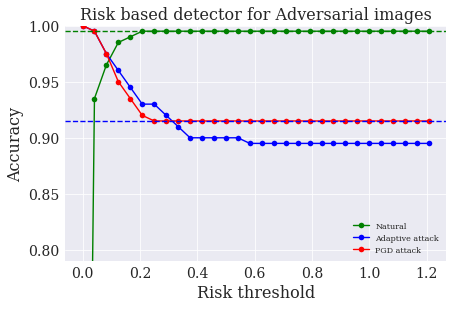

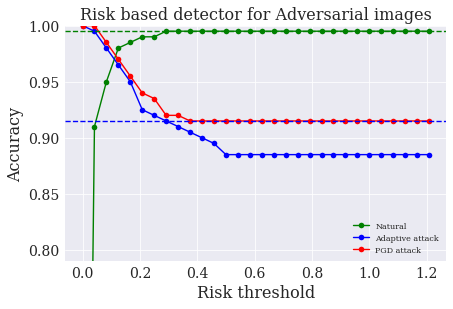

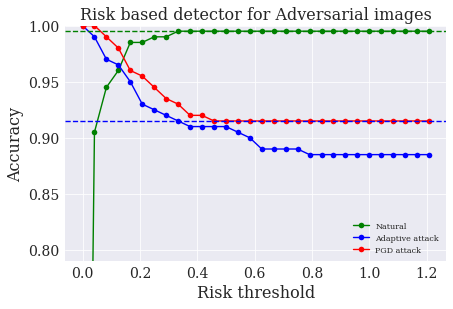

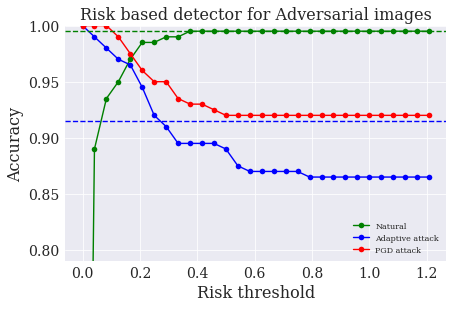

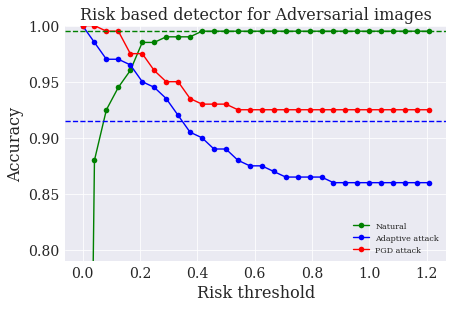

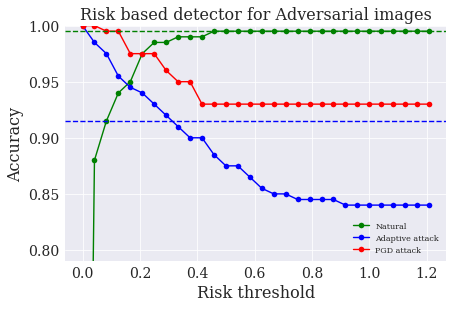

In [83]:
%run ./result_summary_uriya.ipynb
from importlib import reload
import analyze_utilities
reload(analyze_utilities)
import numpy as np

natural_results_path_l, adaptive_results_path_l = analyze_utilities.create_list_of_corresponding_results_by_params(mnist_pgd_natural_diff_refinement, mnist_pgd_adaptive_diff_refinement)
_, pgd_results_path_l = analyze_utilities.create_list_of_corresponding_results_by_params(mnist_pgd_natural_diff_refinement, mnist_pgd_pgd_diff_refinement)
natural_results_path = mnist_pgd_natural_fgsm_all
adaptive_results_path = mnist_bpda1
pgd_results_path = mnist_pgd_pgd_fgsm_all


def adv_risk_detector(natural_results_path, adaptive_results_path, pgd_results_path):
    idx = range(0,200)
    results_dict_natural = analyze_utilities.load_dict_from_file_list(natural_results_path)
    nml_df_natural = analyze_utilities.result_dict_to_nml_df(results_dict_natural)
    _, statistic_natural_df = analyze_utilities.load_results_to_df(natural_results_path, idx=idx)

    results_dict_adaptive = analyze_utilities.load_dict_from_file_list(adaptive_results_path)
    nml_df_adaptive = analyze_utilities.result_dict_to_nml_df(results_dict_adaptive,)
    _, statistic_adaptive_df = analyze_utilities.load_results_to_df(adaptive_results_path, idx=idx)

    results_dict_pgd = analyze_utilities.load_dict_from_file_list(pgd_results_path)
    nml_df_pgd = analyze_utilities.result_dict_to_nml_df(results_dict_pgd)
    _, statistic_pgd_df = analyze_utilities.load_results_to_df(pgd_results_path, idx=idx)

    min_risk_th = 0
    max_risk_th = 1.25
    risk_steps = 30
    risk_th_range = np.arange(min_risk_th, max_risk_th, float(max_risk_th - min_risk_th)/risk_steps)
    statistics_df = pd.DataFrame(columns=['risk_th','acc','adaptive_acc', 'pgd_acc'])

    # statistics_df = pd.concat([statistics_df, statistic_comb_df], ignore_index=False, sort=False)
    for iter, risk_th in enumerate(risk_th_range):
        statistics_detector_natural = analyze_utilities.create_adv_detector_df(nml_df_natural, risk_th, False, idx=idx)
        statistics_detector_adaptive = analyze_utilities.create_adv_detector_df(nml_df_adaptive, risk_th, True, idx=idx)
        statistics_detector_pgd = analyze_utilities.create_adv_detector_df(nml_df_pgd, risk_th, True, idx=idx)
    #     print(statistics_detector_natural)
        statistics_df.loc[iter, 'risk_th'] = float(statistics_detector_natural.loc['risk_th'])
        statistics_df.loc[iter, 'acc'] = float(statistics_detector_natural.loc['acc'])
        statistics_df.loc[iter, 'adaptive_acc'] = float(statistics_detector_adaptive.loc['acc'])
        statistics_df.loc[iter, 'pgd_acc'] = float(statistics_detector_pgd.loc['acc'])
#     print(statistics_df)
    
    plt.figure()
    l1 = plt.plot(statistics_df.risk_th, statistics_df.acc, "go-", label='Natural')
    l2 = plt.plot(statistics_df.risk_th, statistics_df.adaptive_acc, "bo-", label='Adaptive attack')
    l3 = plt.plot(statistics_df.risk_th, statistics_df.pgd_acc, "ro-", label='PGD attack')

    plt.axhline(y=statistic_natural_df.loc["acc", "erm"], color='g', linestyle='--') 
    plt.axhline(y=statistic_pgd_df.loc["acc", "erm"], color='b', linestyle='--')
    plt.legend()
    plt.xlabel("Risk threshold")
    plt.ylabel("Accuracy")
    plt.title('Risk based detector for Adversarial images') #if is_plot_title else None
    plt.legend()
    axes = plt.gca()
    axes.set_ylim([0.79, 1.00])
    plt.savefig(os.path.join(output_path, 'risk_detector_for_adv.jpg'),
                dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None


for i, natural_results_path in enumerate(natural_results_path_l):
    adv_risk_detector([natural_results_path], [adaptive_results_path_l[i]], [pgd_results_path_l[i]])
    
print("Done")

### Combine ERM and pNML using risk

Loading paths from result_summary ...
maximum accuracy is: 0.925
           acc  mean loss  std loss  mean entropy  risk_th
comb_0  0.925   0.153116  0.456129      0.074218    -0.10
comb_1  0.925   0.153116  0.456129      0.074218    -0.06
           acc  mean loss  std loss  mean entropy  risk_th
comb_0   0.925   0.153116  0.456129      0.074218    -0.10
comb_1   0.925   0.153116  0.456129      0.074218    -0.06
comb_2   0.915   0.176042  0.516672      0.074192    -0.02
comb_3   0.910   0.192745  0.571176      0.074967     0.02
comb_4   0.910   0.207738  0.617575      0.077174     0.06
comb_5   0.905   0.221141  0.629607      0.082295     0.10
comb_6   0.905   0.250776  0.686100      0.088273     0.14
comb_7   0.900   0.268170  0.696551      0.098701     0.18
comb_8   0.895   0.279199  0.699644      0.107626     0.22
comb_9   0.885   0.294475  0.704357      0.114614     0.26
comb_10  0.870   0.342033  0.774065      0.128553     0.30
comb_11  0.865   0.369267  0.774162      0.150946   

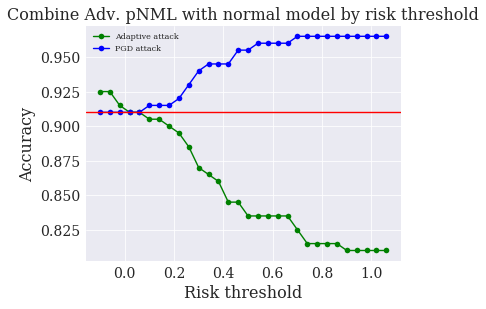

In [58]:
%run ./result_summary_uriya.ipynb
from importlib import reload
import pandas as pd
import numpy as np
import analyze_utilities
reload(analyze_utilities)
from analyze_utilities import *

comb_df_statistics_adaptive = find_optimal_risk_th_for_comb_df(mnist_bpda1)
# print(comb_df_statistics_adaptive)
l1 = plt.plot(comb_df_statistics_adaptive.risk_th, comb_df_statistics_adaptive.acc, "go-", label='Adaptive attack')
comb_df_statistics_pgd = find_optimal_risk_th_for_comb_df(mnist_pgd_pgd_fgsm_all, idx=range(0,200))
# print(comb_df_statistics_pgd)

l2 = plt.plot(comb_df_statistics_pgd.risk_th, comb_df_statistics_pgd.acc, "bo-", label='PGD attack')
plt.axhline(y=comb_df_statistics_pgd.acc[0], color='r', linestyle='-') 
plt.legend()
plt.xlabel("Risk threshold")
plt.ylabel("Accuracy")
plt.title('Combine Adv. pNML with normal model by risk threshold') #if is_plot_title else None
plt.legend()
plt.savefig(os.path.join(output_path, 'combine_normal_model_with_adv_pnml_by_risk.jpg'),
            dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None

## Entropy 

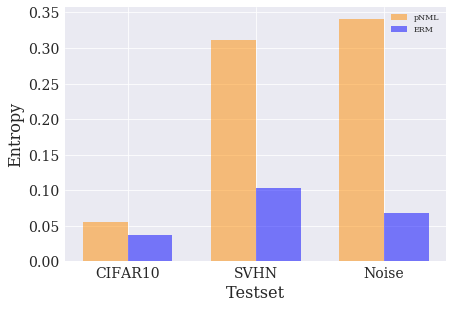


SVHN:
                   nml       erm
acc           0.951900  0.905100
mean loss          NaN       NaN
std loss           NaN       NaN
mean entropy  0.310742  0.103517

Noise:
                   nml       erm
acc           0.939100  0.957700
mean loss          NaN       NaN
std loss           NaN       NaN
mean entropy  0.341066  0.067592


In [29]:
# Plot entropy
objects = ('CIFAR10', 'SVHN', 'Noise')
y_pos = np.arange(len(objects))
bar_width = 0.35
opacity = 0.8

plt.bar(y_pos - bar_width / 2, [statistic_cifar10.loc['mean entropy']['nml'],
                                statistic_svhn.loc['mean entropy']['nml'],
                                statistic_noise.loc['mean entropy']['nml']],
        bar_width, alpha=0.5, color='darkorange', label='pNML')

plt.bar(y_pos + bar_width / 2, [statistic_cifar10.loc['mean entropy']['erm'],
                                statistic_svhn.loc['mean entropy']['erm'],
                                statistic_noise.loc['mean entropy']['erm']],
        bar_width, alpha=0.5, color='blue', label='ERM')

plt.xticks(y_pos, objects)
plt.ylabel('Entropy')
plt.title('Entropy of out of distribution sampels') if is_plot_title else None
plt.legend()
plt.xlabel('Testset')
plt.savefig(os.path.join(output_path, 'out_of_dist_entropy.jpg'),
            dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

print()
print('SVHN:')
print(statistic_svhn)

print()
print('Noise:')
print(statistic_noise)


##  Evaluation Metrices

In [23]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from scipy.ndimage.filters import gaussian_filter
import math
from scipy.stats import ks_2samp


def bhattacharyya(a, b):
    return -np.log(np.sum(np.sqrt(a * b)))


def kl(p, q):
    p = np.asarray(p, dtype=np.float)
    p[p == 0] = np.finfo(float).eps

    q = np.asarray(q, dtype=np.float)
    q[q == 0] = np.finfo(float).eps
    return np.sum(np.where(p > np.finfo(float).eps, - p * np.log(q / p), 0))


def kl_distance(a, b):
    return 0.5*(kl(a, b) + kl(b, a))


def histogram_and_smooth(data, nbins=10, sigma=1):
    hist = np.histogram(data, bins=nbins)[0]
    hist_smooth = gaussian_filter(hist, sigma)
    hist_smooth_normalized = hist_smooth/np.sum(hist_smooth)
    return hist_smooth_normalized


def calc_p_lamb(a_distribution, b_distribution, lamb):
    """
    Calc P_lamb distribution: P_lambda = a^lamb * b^(1-lamb) / Normalize
    """
    p_lamb = np.power(a_distribution, lamb) * np.power(b_distribution, 1-lamb)
    p_lamb /= np.sum(p_lamb)
    return p_lamb


def find_lamb_star(a_distribution, b_distribution):
    """
    Find lambda^* for which D(a||P_lambda) = D(b||P_lambda) 
    """
    distance = []
    lamb_list = np.flip(np.linspace(0, 1, 20))

    # For each lambda calculate the Distance D(a||P_lambda) - D(b||P_lambda)
    for lamb in lamb_list:
        p_lamb = calc_p_lamb(a_distribution, b_distribution, lamb)
        distance.append(kl(p_lamb, a_distribution) -
                        kl(p_lamb, b_distribution))

    # Find lambda for which the the distance is zero
    lamb_star = np.interp(0.0, distance, lamb_list)

    # Get the KL value in that lamb_star: D(a||P_lambda)
    p_lamb_star = calc_p_lamb(a_distribution, b_distribution, lamb_star)
    return kl(p_lamb_star, a_distribution)


def calc_performance_in_out_dist(true_ind, score_ind):
    """
    Calculate evaluation matrics
    """
    score_ood = 1 - np.array(score_ind)
    true_ood = 1 - np.array(true_ind)

    true_len = np.sum(true_ind)
    false_len = len(true_ind) - true_len
    sample_weight = [1] * true_len + [true_len / false_len] * false_len

    # AUROC
    res_auc = roc_auc_score(true_ood, score_ood, sample_weight=sample_weight)

    # AUPR-Out
    ap_out = average_precision_score(
        true_ood, score_ood, sample_weight=sample_weight)

    # AUPR-In
    ap_in = average_precision_score(
        true_ind, score_ind, sample_weight=sample_weight)

    # KL distance
    score_ind = np.array(score_ind)
    true_ind = np.array(true_ind)
    in_hist = histogram_and_smooth(
        score_ind[true_ind == True], nbins=20, sigma=0)
    out_hist = histogram_and_smooth(
        score_ind[true_ind == False], nbins=20, sigma=0)
    kl_dist = kl_distance(in_hist, out_hist)

    # Bhattacharyya distance
    bhatt_dist = bhattacharyya(in_hist, out_hist)

    # P_lambda
    kl_in_p_lambda = find_lamb_star(in_hist, out_hist)

    ood_df = pd.DataFrame({
        # 'AUROC': [res_auc], 'AP-In': [ap_in], 'AP-Out': [ap_out],
        'KL Divergence': [kl_dist], 'Bhattach Distance': [bhatt_dist],
        'KL in P_lamb': [kl_in_p_lambda]
    })

    return ood_df

Upsample ratio:  1
FGSM:
          KL Divergence  Bhattach Distance  KL in P_lamb
Max Prob       0.051983           0.011072      0.011077
1-p2/p1        0.037862           0.009395      0.009424
Regret         6.924417           1.707655      1.922269



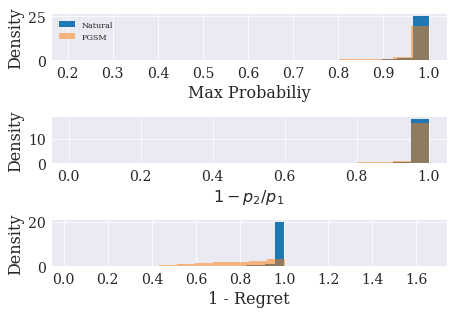

Upsample ratio:  1
PGD:
          KL Divergence  Bhattach Distance  KL in P_lamb
Max Prob       0.187580           0.046758      0.046978
1-p2/p1        0.173888           0.042991      0.043269
Regret         6.570924           1.969086      2.080867



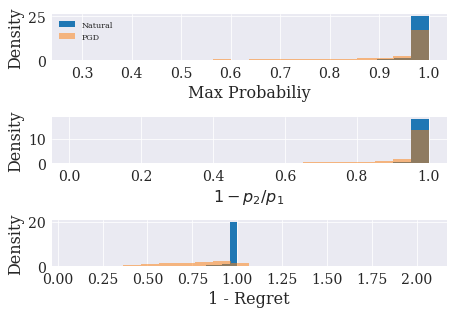

Upsample ratio:  50
Adaptive:
          KL Divergence  Bhattach Distance  KL in P_lamb
Max Prob       0.389235           0.035355      0.035444
1-p2/p1        0.223241           0.024271      0.024247
Regret         2.469903           0.676119      0.677879



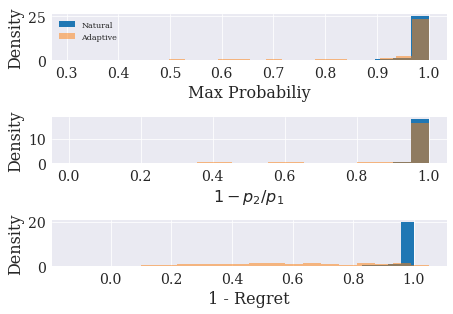

In [29]:
from numpy import inf
ind_df = results_df_natural
for (ooo_dataset, ood_df) in zip(['FGSM', 'PGD', 'Adaptive'], [results_df_fgsm, results_df_pgd, results_df_adaptive]):
    upsample_ratio = int(ind_df.shape[0] / ood_df.shape[0])
    print('Upsample ratio: ', upsample_ratio)

    # Baseline Max prob of ERM
    y_score_ind = ind_df[['erm_' + str(x) for x in range(10)]].max(axis=1).tolist() + \
        ood_df[['erm_' + str(x) for x in range(10)]].max(axis=1).tolist()
    y_true_ind = [True] * ind_df.shape[0] + [False] * ood_df.shape[0]
    ood_df_erm_baseline = calc_performance_in_out_dist(y_true_ind, y_score_ind)
    ood_df_erm_baseline = ood_df_erm_baseline.rename(index={0: 'Max Prob'})
    
    # Baseline p1/p2 of ERM
    p1_ind = np.sort(ind_df[['erm_' + str(x) for x in range(10)]])[:,-2:][:,1]
    p2_ind = np.sort(ind_df[['erm_' + str(x) for x in range(10)]])[:,-2:][:,0]
    p1_p2_ind = 1-p2_ind/p1_ind #np.clip(p1_ind/p2_ind, 0, 10**6) 
    p1_ood = np.sort(ood_df[['erm_' + str(x) for x in range(10)]])[:,-2:][:,1]
    p2_ood = np.sort(ood_df[['erm_' + str(x) for x in range(10)]])[:,-2:][:,0]
    p1_p2_ood= 1-p2_ood/p1_ood#np.clip(p1_ood/p2_ood, 0, 10**6) 


    y_score_ind = list(p1_p2_ind) + list(p1_p2_ood)
    y_true_ind = [True] * ind_df.shape[0] + [False] * ood_df.shape[0]
    ood_df_erm_baseline_2 = calc_performance_in_out_dist(y_true_ind, y_score_ind)
    ood_df_erm_baseline_2 = ood_df_erm_baseline_2.rename(index={0: '1-p2/p1'})

    # Regret based
    y_score_ind = (1.0 - ind_df['log_norm_factor']).tolist() + \
                  (1.0 - ood_df['log_norm_factor']).tolist()
    y_true_ind = [True] * ind_df.shape[0] + [False] * ood_df.shape[0]

    ood_df_ours = calc_performance_in_out_dist(y_true_ind, y_score_ind)
    ood_df_ours = ood_df_ours.rename(index={0: 'Regret'})

    # Summary
    merged_pd = pd.concat([ood_df_erm_baseline, ood_df_erm_baseline_2, ood_df_ours])
    print('%s:' % ooo_dataset)
    print(merged_pd)
    print()

    # Histogram based on Ouf Of Dist confidence
    f, axarr = plt.subplots(3, 1)
    nbins = 20
    axarr[0].hist(ind_df[['erm_' + str(x) for x in range(10)]
                         ].max(axis=1),  bins=nbins, alpha=1.0, density=True, label='Natural')
    axarr[0].hist(ood_df[['erm_' + str(x) for x in range(10)]
                         ].max(axis=1),  bins=nbins, alpha=0.5, density=True, label=ooo_dataset)
    axarr[0].set_xlabel('Max Probabiliy')
    axarr[0].set_ylabel('Density')
    axarr[0].legend()

    axarr[1].hist(list(p1_p2_ind), bins=nbins,
                  alpha=1.0, density=True, label='In-Dist')
    axarr[1].hist(list(p1_p2_ood),bins=nbins,
                  alpha=0.5, density=True, label=ooo_dataset)
    axarr[1].set_xlabel(r'$1-p_2 / p_1$')
    axarr[1].set_ylabel('Density')       

    axarr[2].hist(1.0 - ind_df['log_norm_factor'], bins=nbins,
                  alpha=1.0, density=True, label='In-Dist')
    axarr[2].hist(1.0 - ood_df['log_norm_factor'],bins=nbins,
                  alpha=0.5, density=True, label=ooo_dataset)
    axarr[2].set_xlabel('1 - Regret')
    axarr[2].set_ylabel('Density')
    
    f.subplots_adjust(hspace=0.6)
    plt.savefig(os.path.join(output_path, 'out_of_dist_detection_%s.jpg' % ooo_dataset),
            dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
    plt.show()

In [ ]:
# p1 = np.array(ind_df[['erm_' + str(x) for x in range(10)]].max(axis=1))
p1 = np.sort(ind_df[['erm_' + str(x) for x in range(10)]])[:,-2:][:,1]
p2 = np.sort(ind_df[['erm_' + str(x) for x in range(10)]])[:,-2:][:,0]
print('p1')
print(p1)
print('p2')
print(p2)

In [ ]:
bins = 10**(np.arange(0,6))
bins

# Random labels

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import json
from analyze_utilities import *
from dataset_utilities import create_cifar10_dataloaders
import pandas as pd
import copy

% run ./result_summary.ipynb

In [ ]:
# Count param difference between WideResnet and Resnet20
from wide_resnet import WideResNet
from resnet import resnet20

model = WideResNet()
wide_resnet_params = sum(p.numel() for p in model.parameters())
model = resnet20()
resnet20_params = sum(p.numel() for p in model.parameters())
print('[WideResnet Resnet20]=[{} {}]'.format(
    wide_resnet_params, resnet20_params))
print('Ratio {}]'.format(wide_resnet_params / resnet20_params))

In [ ]:
# Extract the log normalization factor
random_df = pd.DataFrame(columns=['nml_acc', 'erm_acc', 'genie_acc',
                                  'log10_norm_factor',
                                  'nml_mean_loss', 'erm_mean_loss', 'genie_mean_loss'])

for (rand_prob_single, file_random) in zip(random_prob, files_random):
    results_df, statistics_df = load_results_to_df(file_random)
    print('Random Prob = {}, num={}'.format(
        rand_prob_single, results_df.shape[0]))
    random_df.loc[rand_prob_single] = [statistics_df.loc['acc']['nml'],
                                       statistics_df.loc['acc']['erm'],
                                       statistics_df.loc['acc']['genie'],
                                       results_df['log10_norm_factor'].mean(),
                                       statistics_df.loc['mean loss']['nml'],
                                       statistics_df.loc['mean loss']['erm'],
                                       statistics_df.loc['mean loss']['genie']]
print('Random df:')
random_df.transpose().round(2)

In [ ]:
# Plot
plt.plot(random_df.index.values,
         random_df['log10_norm_factor'], '--*', label='NML')
plt.ylabel('Regret')
plt.xlabel('Prob of random')
plt.title('Regret Vs. Prob to be Random') if is_plot_title else None
# plt.savefig(os.path.join(output_path, 'random_prob_regret.jpg'),
#             dpi=200, bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

In [ ]:
# Check noisy data
plt.plot(random_df.index.values, random_df['erm_mean_loss'], label='ERM')
plt.plot(random_df.index.values, random_df['nml_mean_loss'], label='pNML')
plt.plot(random_df.index.values, random_df['genie_mean_loss'], label='Genie')
plt.title('Loss of random labels') if is_plot_title else None
plt.ylabel('Loss')
plt.xlabel('Prob to be Random')
plt.legend()
plt.savefig(os.path.join(output_path, 'random_prob_loss.jpg'), dpi=200,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

plt.plot(random_df.index.values, random_df['erm_acc'], label='ERM')
plt.plot(random_df.index.values, random_df['nml_acc'], label='pNML')
plt.plot(random_df.index.values, random_df['genie_acc'], label='Genie')
plt.title('Acc of random labels') if is_plot_title else None
plt.ylabel('Acc')
plt.xlabel('Prob to be Random')
plt.legend()
plt.savefig(os.path.join(output_path, 'random_prob_acc.jpg'), dpi=200,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline
def smooth_graph(x, y, pow=1):

    x_smooth = np.linspace(x.min(), x.max(), 300)
    spl = make_interp_spline(x, y, k=pow)
    y_smooth = spl(x_smooth)
    return x_smooth, y_smooth

# Check noisy data
color = 'royalblue'
fig, ax1 = plt.subplots()

x, y = smooth_graph(random_df.index.values, random_df['erm_mean_loss'])
ax1.plot(x, y, label='ERM log-loss')

x, y = smooth_graph(random_df.index.values, random_df['nml_mean_loss'])
ax1.plot(x, y, label='pNML log-loss')

ax1.set_ylabel('Loss')
ax1.set_ylabel('Log-loss')
ax1.set_xlabel('Prob to be random')

# # Plot
# ax2 = ax1.twinx()
# x, y = smooth_graph(random_df.index.values, random_df['log10_norm_factor'])
# ax2.plot(x, y, color='indianred', label='Regret')
# ax2.set_ylabel('Regret')

# # ax2 ticks
# l = ax1.get_ylim()
# l2 = ax2.get_ylim()


# def f(x): return l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])


# ticks = f(ax1.get_yticks())
# ax2.yaxis.set_major_locator(mpl.ticker.FixedLocator(ticks))
# ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

# # Legends
# ax1.legend(loc=(.04, .86), frameon=False)
# ax2.legend(loc=(.04, .94), frameon=False)
ax1.legend()

plt.savefig(os.path.join(output_path, 'random_prob_regret_and_loss.jpg'), dpi=200,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

# Twice Universality

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import json
from analyze_utilities import *
from dataset_utilities import create_cifar10_dataloaders
import pandas as pd
import copy
import collections

%run ./result_summary_uriya.ipynb

### Cifar

In [ ]:
print('load 0 layers')
nml_0_df = result_dict_to_erm_df(load_dict_from_file_list(files_nml_2_layers))
print('load 2 layers')
nml_2_df = result_dict_to_nml_df(load_dict_from_file_list(files_nml_2_layers))
print('load 7 layers')
nml_7_df = result_dict_to_nml_df(load_dict_from_file_list(files_nml_7_layers))

# Create twice df dataframe
twice_df, idx_common = create_twice_univ_df([nml_0_df, nml_2_df, nml_7_df])
twice_statistic_df = calc_statistic_from_df_single(twice_df).rename(columns={'statistics': 'Twice Univ'})

# Print statistic of all
twice_statistic_df = calc_statistic_from_df_single(twice_df).rename(columns={'statistics': 'Twice Univ'})
nml_0_statistic_df = calc_statistic_from_df_single(nml_0_df.loc[idx_common]).rename(columns={'statistics':
                                                                                                 '0 layers'})
nml_2_statistic_df = calc_statistic_from_df_single(nml_2_df.loc[idx_common]).rename(columns={'statistics':
                                                                                                 '2 layers'})
nml_7_statistic_df = calc_statistic_from_df_single(nml_7_df.loc[idx_common]).rename(columns={'statistics':
                                                                                                 '7 layers'})
#--
print(pd.concat([twice_statistic_df,
                 nml_0_statistic_df,
                 nml_2_statistic_df,
                 nml_7_statistic_df], axis=1, join='inner').transpose())


### MNIST

In [ ]:
twice_stats_df_concat = pd.DataFrame([])
M1_stats_df_concat = pd.DataFrame([])
M2_stats_df_concat = pd.DataFrame([])
bagging_stats_df_concat = pd.DataFrame([])
risk_min_stats_df_concat = pd.DataFrame([])

for i in range(len(M1_list)):
    M1_path = M1_list[i]
    M2_path = M2_list[i]

    M1 = result_dict_to_nml_df(load_dict_from_file_list(M1_path))
    print('loaded 0 layers MNIST, {} samples'.format(M1.shape[0]))
    M2 = result_dict_to_nml_df(load_dict_from_file_list(M2_path))
    print('loaded 1 layers MNIST, {} samples'.format(M2.shape[0]))

    # Create twice_df dataframe
    twice_df, idx_common = create_twice_univ_df([M1, M2])

    # create genie dataframe for twice_univ
    genie_tu_df, _ = create_genie_tu_df([M1, M2])
    
    # create bagging dataframe
    bagging_df, _ = create_bagging_df([M1, M2])
    
    # create risk minimizer dataframe
    risk_min_df, _ = create_risk_minimizer_df([M1, M2])
    
    # Print statistic of all
    twice_statistic_df = calc_statistic_from_df_single(twice_df).rename(columns={'statistics': 'Twice Univ'})
    twice_stats_df_concat = pd.concat([twice_stats_df_concat, twice_statistic_df.transpose()])
    
    genie_statistic_df = calc_statistic_from_df_single(genie_tu_df).rename(columns={'statistics': 'Genie Twice Univ'})
    counter_genie_sel_df = collections.Counter(genie_tu_df["selected_df"])
    
    bagging_stats_df = calc_statistic_from_df_single(bagging_df).rename(columns={'statistics': 'Bagging'})
    bagging_stats_df_concat = pd.concat([bagging_stats_df_concat, bagging_stats_df.transpose()])
    
    risk_min_stats_df = calc_statistic_from_df_single(risk_min_df).rename(columns={'statistics': 'Risk minimizer'})
    risk_min_stats_df_concat = pd.concat([risk_min_stats_df_concat, risk_min_stats_df.transpose()])
    counter_riskmin_sel_df = collections.Counter(risk_min_df["selected_df"])
    
    M1_statistic_df = calc_statistic_from_df_single(M1.loc[idx_common]).rename(columns={'statistics':
                                                                                                     'M1_nml'})
    M1_stats_df_concat = pd.concat([M1_stats_df_concat, M1_statistic_df.transpose()])
    M2_statistic_df = calc_statistic_from_df_single(M2.loc[idx_common]).rename(columns={'statistics':
                                                                                                     'M2_nml'})
    M2_stats_df_concat = pd.concat([M2_stats_df_concat, M2_statistic_df.transpose()])

    _, statistics_df1 = load_results_to_df(M1_path, idx=idx_common )
    statistics_df1 = statistics_df1.rename(columns={'erm': 'M1_erm', 'genie':'M1_genie'})
    _, statistics_df2 = load_results_to_df(M2_path, idx=idx_common )
    statistics_df2 = statistics_df2.rename(columns={'erm': 'M2_erm', 'genie':'M2_genie'})
    # nml_2_statistic_df = calc_statistic_from_df_single(nml_2_df.loc[idx_common]).rename(columns={'statistics':
    #                                                                                                  '2 layers'})
    #--
#     print('Num of common index {}'.format(twice_df.shape[0]))
    print(pd.concat([twice_statistic_df,
                     genie_statistic_df,
                     M1_statistic_df,
                     M2_statistic_df,
                     bagging_stats_df,
                     risk_min_stats_df,
                     statistics_df1[['M1_erm','M1_genie']],
                     statistics_df2[['M2_erm','M2_genie']],], axis=1, join='inner').transpose())
    print("Genie selected M1 %d times \nRisk minimizer selected M1 %d times" % 
                              (counter_genie_sel_df[0], counter_riskmin_sel_df[0]))

print()
mean_stats = pd.concat([twice_stats_df_concat.mean(axis=0).rename('Twice Univ'),
                       M1_stats_df_concat.mean(axis=0).rename('M1_nml'),
                       M2_stats_df_concat.mean(axis=0).rename('M2_nml'),
                       bagging_stats_df_concat.mean(axis=0).rename('Bagging'),
                       risk_min_stats_df_concat.mean(axis=0).rename('Risk minimizer')], axis=1)
print(mean_stats.transpose())                        
# print(twice_stats_df_concat.mean(axis=0).columns)
# print(M1_stats_df_concat.mean(axis=0).transpose())
# print(M2_stats_df_concat.mean(axis=0).transpose())


# Adversarial Attack 

In [ ]:
import seaborn as sns
adversarial_df = pd.DataFrame(columns=['regret',
                                       'erm_acc', 'nml_acc', 'genie_acc',
                                       'erm_mean_loss', 'nml_mean_loss', 'genie_mean_loss',
                                       'nml_std_loss', 'std_regret'])
fig = plt.figure(figsize=(20, 6 * len(adversarial_epsilon)))

# Get common indexes from all adeversarail experiments
_, idx_common = get_testset_intersections_from_results_dfs(
    [result_dict_to_erm_df(load_dict_from_file_list(file)) for file in files_adversarial])
adversarial_nml_df = []
eps = []
for i, (epsilon_single, file_adversarial) in enumerate(zip(adversarial_epsilon, files_adversarial)):

    # Load results dict into dataframe
    results_dict = load_dict_from_file_list(file_adversarial)
    erm_df = result_dict_to_erm_df(results_dict).loc[idx_common]
    nml_df = result_dict_to_nml_df(results_dict).loc[idx_common]
    genie_df = result_dict_to_genie_df(results_dict).loc[idx_common]
    
    adversarial_nml_df.append(nml_df)
    eps.append(epsilon_single)

    # Analyze statistic of single adversarial experimnet
    statistics_erm_df = calc_statistic_from_df_single(erm_df)
    statistics_nml_df = calc_statistic_from_df_single(nml_df)
    statistics_genie_df = calc_statistic_from_df_single(genie_df)

    print('epsilon = {}, num={}'.format(epsilon_single, nml_df.shape[0]))
    adversarial_df.loc[epsilon_single] = [nml_df['log10_norm_factor'].mean(),
                                          statistics_erm_df.loc['acc'][0],
                                          statistics_nml_df.loc['acc'][0],
                                          statistics_genie_df.loc['acc'][0],
                                          statistics_erm_df.loc['mean loss'][0],
                                          statistics_nml_df.loc['mean loss'][0],
                                          statistics_genie_df.loc['mean loss'][0],
                                          statistics_nml_df.loc['std loss'][0],
                                          nml_df['log10_norm_factor'].std()]
    # Plot the image
#     g = sns.JointGrid(x="log10_norm_factor", y="loss", data=nml_df)
#     g.plot_marginals(sns.kdeplot, shade=True, color='red')
#     g.plot_joint(plt.hist2d, bins=[100, 100],  # norm=mpl.colors.SymLogNorm(0.1),
#                  cmin=1, cmap=plt.cm.Reds)
#     g.ax_joint.grid(True)
#     g.ax_joint.set_ylabel('Log-loss')
#     g.ax_joint.set_xlabel('Regret, $\epsilon$={}'.format(epsilon_single))
#     # make new ax object for the cbar
#     plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
#     cbar_ax = g.fig.add_axes([.82, .2, .05, .5])  # x, y, width, height
#     plt.colorbar(cax=cbar_ax).set_label(label='Count')
#     cbar_ax.tick_params(labelsize=12)

#     plt.show()

print('Adversarial dataframe: Performances\Epsilon')
adversarial_df = adversarial_df.iloc[::-1]
adversarial_df.transpose().round(2)

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter


def smooth_graph(x, y, pow=1):

    x_smooth = np.linspace(x.min(), x.max(), 300)
    spl = make_interp_spline(x, y, k=pow)
    y_smooth = spl(x_smooth)
    return x_smooth, y_smooth


# Check noisy data
color = 'royalblue'
fig, ax1 = plt.subplots()

x, y = smooth_graph(adversarial_df.index.values,
                    adversarial_df['erm_mean_loss'])
ax1.plot(x, y, label='ERM log-loss')

x, y = smooth_graph(adversarial_df.index.values,
                    adversarial_df['nml_mean_loss'])
ax1.plot(x, y, label='pNML log-loss')

ax1.set_ylabel('Loss')
ax1.set_ylabel('Log-loss')
ax1.set_xlabel('$\epsilon$')
ax1.set_xscale('log',  basex=10)
for axis in [ax1.xaxis, ax1.yaxis]:
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    axis.set_major_formatter(formatter)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# # Plot
# ax2 = ax1.twinx()
# x, y = smooth_graph(adversarial_df.index.values, adversarial_df['regret'])
# ax2.plot(x, y, color='indianred', label='Regret')
# ax2.set_ylabel('Regret')

# # ax2 ticks
# l = ax1.get_ylim()
# l2 = ax2.get_ylim()


# def f(x): return l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])


# ticks = f(ax1.get_yticks())
# ax2.yaxis.set_major_locator(mpl.ticker.FixedLocator(ticks))
# ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

# # Legends
# ax1.legend(loc=(.04, .835), frameon=False)
# ax2.legend(loc=(.04, .925), frameon=False)
ax1.legend()
plt.savefig(os.path.join(output_path, 'epsilon_regret_and_loss.jpg'), dpi=200,
            bbox_inches=plt.tight_layout()) if is_save_fig else None
plt.show()

In [ ]:
ind_df = adversarial_nml_df[-1] # get last member in the list. it is epsilon=0


for (ooo_dataset, ooo_df) in zip(eps, adversarial_nml_df):
    upsample_ratio = int(ind_df.shape[0] / ooo_df.shape[0])
    print('Upsample ratio: ', upsample_ratio)


    # Regret based
    y_score_ind = (1.0 - ind_df['log10_norm_factor']).tolist() + \
                  (1.0 - ooo_df['log10_norm_factor']).tolist()
    y_true_ind = [True] * ind_df.shape[0] + [False] * ooo_df.shape[0]

    ood_df_ours = calc_performance_in_out_dist(y_true_ind, y_score_ind)
    ood_df_ours = ood_df_ours.rename(index={0: 'Regret'})

    # Summary
    merged_pd =  ood_df_ours #pd.concat([ood_df_erm_baseline, ood_df_ours])
    print('%s:' % ooo_dataset)
    print(merged_pd.round(2))
    print()


# Visualize False classified
Visaulaize the image of the false classified by the ERM and NML

In [ ]:
result_df.head()

In [ ]:
# Check when erm and nml are not agree
disagree = np.logical_not(
    np.logical_and(np.array(result_df['nml_is_correct']), np.array(np.array(result_df['erm_is_correct']))))
disagree_indxes = np.array(result_df.index.values)[disagree == True].astype(np.int).tolist()
print(disagree_indxes)


In [ ]:
# Given a dict an idx, visualize ERM and NMl with prob of each. along with ground truth

# Inputs
results_dict = load_dict_from_file_list(files_nml_2_layers)
dict_idxes = [158, 384, 456]  #disagree_indxes # [245, 246]

# Initialize dataset and plots
fig = plt.figure(figsize=(20, 6 * len(dict_idxes)))
trainloader, testloader, classes = create_cifar10_dataloaders('../data', 1, 1)

# Loop on dict indxes
for iter_idx, dict_idx in enumerate(dict_idxes):
    prob_nml, true_label, predicted_label, prob_erm = extract_probabilities_list(results_dict[str(dict_idx)])
    prob_nml, normalization_factor = execute_normalize_prob(prob_nml)

    # Extract class names
    class_predict_nml = classes[np.argmax(prob_nml)]
    class_predict_erm = classes[np.argmax(prob_erm)]
    class_predict_gt = classes[true_label]
    # Extract image
    data = testloader.dataset.test_data[dict_idx]

    # Plot the image
    ax = fig.add_subplot(len(dict_idxes), 1, iter_idx + 1)
    ax.imshow(data)
    ax.set_title('[NML ERM True] = Label: {} \n [NML ERM] Prob: {}'
                 .format([class_predict_nml, class_predict_erm, class_predict_gt],
                         np.round([prob_nml[np.argmax(prob_nml)], prob_erm[np.argmax(prob_erm)]], 3)))

plt.show()
